# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - **minimum required spend** to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in **hours** since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# A .  What to do

### Goal/Achievements
To combine transaction, demographic and offer data to determine **which demographic groups respond best to which offer type.**

### Way how to do

- **A machine learning model** that predicts **how much someone will spend based on demographics and offer type**. 
- **A model** that predicts **whether or not someone will respond to an offer**.
- **A set of heuristics** that determine **what offer you should send to each customer** (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

### About Data

- **Once every few days**, Starbucks sends out **an offer to users of the mobile app**. An offer can be merely an advertisement for a drink or an actual offer such as a **discount** or **BOGO (buy one get one free)**. Some users might **not** receive any offer during certain weeks. 

- Every offer has a **validity period** before the offer expires.  

- **informational offers** have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, **you can assume the customer is feeling the influence of the offer for 7 days** after receiving the advertisement.

- transactional data showing user purchases **made on the app** including the **timestamp of purchase** and the **amount of money spent** on a purchase. 

- transactional data also has a record for each offer that a user receives as well as a record for **when a user actually views the offer**. There are also records for **when a user completes an offer**. 

- **someone using the app** might make a purchase through the app **without having received an offer or seen an offer**.

- **a user can receive an offer, never actually view the offer, and still complete the offer**. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, **the customer was not influenced by the offer because the customer never viewed the offer**.

- **Some demographic groups will make purchases even if they don't receive an offer**. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. **You'll want to try to assess what a certain demographic group will buy when not receiving any offers**.

### Question

- which demographic groups respond best to which offer type
> - *receive/view/complete*
> - *receive/view*
> - *receive/not view/complete*
> - *not receive/transaction*
> - *information/transaction*
- how much someone will spend based on demographics and offer type


# B. Data Pre_processing

## 1. `portfolio` Dataframe

In [2]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [4]:
portfolio = portfolio.copy()

In [5]:
# change Dtype of 'duration' to datetime
portfolio['duration'] = pd.to_datetime(portfolio['duration'], format='%d').dt.day

In [6]:
# rename 'id' to 'offer_id'
portfolio.rename(columns={'id':'offer_id'}, inplace=True)

In [7]:
portfolio

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


## 2. `profile` Dataframe

In [8]:
profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [9]:
profile = profile.copy()

In [10]:
# change Dtype of 'became_member_on' to datetime
profile['became_member_on']=profile['became_member_on'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [11]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  object        
 1   age               17000 non-null  int64         
 2   id                17000 non-null  object        
 3   became_member_on  17000 non-null  datetime64[ns]
 4   income            14825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 664.2+ KB


In [12]:
def create_loyalty(profile=profile):
    
    '''
    create 'loyalty' column, the duration between latest date of membership and the date of 'became_member_on'
    imput: profile df
    output: profile df with loyalty column
    
    '''
    latest = profile.became_member_on.max()
    membership_duration = (latest - profile.became_member_on).dt.days
    profile['loyalty'] = membership_duration
    
    return profile

profiles = create_loyalty() 
profiles

,gender,age,id,became_member_on,income,loyalty
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,529
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,376
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,14
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,443
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,356
...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,52
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,13
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,546
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,871


In [13]:
# check what is age 118
profile_118 = profiles.query('age == "118"')
profile_118.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
loyalty                0
dtype: int64

In [14]:
# create 'profile' without age '118'
profile = profiles.query('age !="118"')
profile

,gender,age,id,became_member_on,income,loyalty
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,376
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,443
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,91
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,167
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,257
...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,52
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,13
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,546
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,871


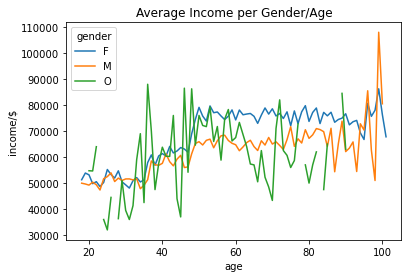

In [15]:
# plot average income per age/gender 
profile.pivot_table('income', index ='age', columns='gender', aggfunc='mean').plot();
plt.title('Average Income per Gender/Age');
plt.ylabel('income/$');

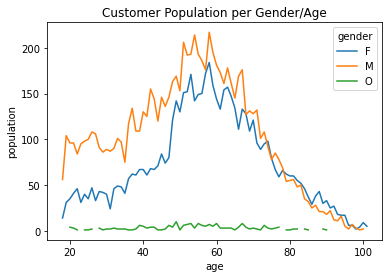

In [16]:
# plot population per age/gender
profile.pivot_table('income', index ='age', columns='gender', aggfunc='count').plot();
plt.title('Customer Population per Gender/Age');
plt.ylabel('population');

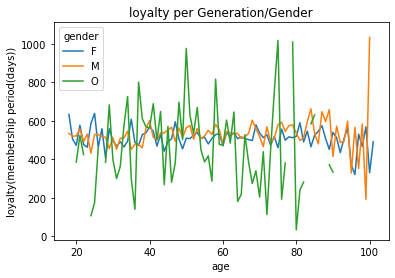

In [17]:
# plot loyalty per age and gender
profile.pivot_table('loyalty', index ='age', columns='gender', aggfunc='mean').plot();
plt.title('loyalty per Generation/Gender');
plt.ylabel('loyalty(membership period(days))');

In [18]:
# crate personal_data df
personal_data = profile.drop_duplicates()
personal_data

,gender,age,id,became_member_on,income,loyalty
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,376
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,443
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,91
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,167
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,257
...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,52
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,13
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,546
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,871


In [19]:
# rename 'id' column to 'person' 
personal_data.rename(columns={'id':'person'}, inplace=True)

## 3. `transcript` Dataframe

In [20]:
transcript = transcript.copy()

In [21]:
transcript = transcript.sort_values(['person','time'])
transcript

,person,event,value,time
55972,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168
77705,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192
89291,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228
113605,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336
139992,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372
...,...,...,...,...
258361,ffff82501cea40309d5fdd7edcca4a07,transaction,{'amount': 14.23},576
258362,ffff82501cea40309d5fdd7edcca4a07,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,576
262475,ffff82501cea40309d5fdd7edcca4a07,offer viewed,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},582
274809,ffff82501cea40309d5fdd7edcca4a07,transaction,{'amount': 10.12},606


In [22]:
def events_filter(event_list, df):
    
    '''
    filter by each event, 'offer_received','offer_viewed', 'offer_completed' and 'transaction'
    input: [event]
    output: df 'event'
    '''
    event_df = df.loc[df['event'].isin([event_list])]    
    
    return event_df     

In [23]:
# the number of 'transaction'
events_filter('transaction', transcript).shape[0]

138953

In [24]:
# the number of 'offer completed' 
events_filter('offer completed', transcript).shape[0]

33579

In [25]:
# create 'offer received' df
offer_received=events_filter('offer received', transcript)
offer_received

,person,event,value,time
55972,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168
113605,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336
153401,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},408
204340,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},504
247879,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},576
...,...,...,...,...
54574,ffff82501cea40309d5fdd7edcca4a07,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},168
112214,ffff82501cea40309d5fdd7edcca4a07,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},336
152030,ffff82501cea40309d5fdd7edcca4a07,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},408
202962,ffff82501cea40309d5fdd7edcca4a07,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},504


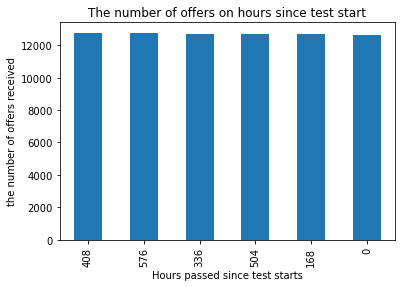

In [26]:
# check when offers were received and how many on that timmings
offer_received.time.value_counts().plot(kind='bar');
plt.title('The number of offers on hours since test start');
plt.xlabel('Hours passed since test starts');
plt.ylabel('the number of offers received');

In [27]:
offer_received.time.value_counts()

408    12778
576    12765
336    12711
504    12704
168    12669
0      12650
Name: time, dtype: int64

> offers were given at the same time in 6 timings.  

In [28]:
def transcript_clean(df=transcript):
    '''
    clean transcript Dataframe
    imput: transcript df
    output: cleaned transcript df
    '''
    # convert dict of value column to pd.Series and concat to transcript df
    transcript = pd.concat([df, df['value'].apply(pd.Series)],axis=1).sort_values(['person','time'])
    
    # offer id == null & offer_id ==not null ==> offer_id
    # otherwise ==> offer id
    transcript['offer']= np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(),
                                  transcript['offer_id'], transcript['offer id'])
    
    transcript.drop(['offer id','offer_id'],axis=1,inplace=True)
    
    transcript.rename(columns={'offer':'offer_id'}, inplace=True)
    
    transcript = transcript.merge(personal_data,how='left',on='person')
    
        
    return transcript

transcript = transcript_clean()
transcript.head()

,person,event,value,time,amount,reward,offer_id,gender,age,became_member_on,income,loyalty
0,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,M,33.0,2017-04-21,72000.0,461.0
1,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,M,33.0,2017-04-21,72000.0,461.0
2,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228,22.16,NaN,NaN,M,33.0,2017-04-21,72000.0,461.0
3,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336,NaN,NaN,3f207df678b143eea3cee63160fa8bed,M,33.0,2017-04-21,72000.0,461.0
4,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372,NaN,NaN,3f207df678b143eea3cee63160fa8bed,M,33.0,2017-04-21,72000.0,461.0


## 4. `transcript` merge with `portfolio`

In [29]:
# create transcript df by merge with portfolio df
transcript = transcript.merge(portfolio,how='left',on='offer_id')
transcript

,person,event,value,time,amount,reward_x,offer_id,gender,age,became_member_on,income,loyalty,reward_y,channels,difficulty,duration,offer_type
0,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,M,33.0,2017-04-21,72000.0,461.0,0.0,"[email, mobile, social]",0.0,3.0,informational
1,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,M,33.0,2017-04-21,72000.0,461.0,0.0,"[email, mobile, social]",0.0,3.0,informational
2,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228,22.16,NaN,NaN,M,33.0,2017-04-21,72000.0,461.0,NaN,NaN,NaN,NaN,NaN
3,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336,NaN,NaN,3f207df678b143eea3cee63160fa8bed,M,33.0,2017-04-21,72000.0,461.0,0.0,"[web, email, mobile]",0.0,4.0,informational
4,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372,NaN,NaN,3f207df678b143eea3cee63160fa8bed,M,33.0,2017-04-21,72000.0,461.0,0.0,"[web, email, mobile]",0.0,4.0,informational
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,ffff82501cea40309d5fdd7edcca4a07,transaction,{'amount': 14.23},576,14.23,NaN,NaN,F,45.0,2016-11-25,62000.0,608.0,NaN,NaN,NaN,NaN,NaN
306530,ffff82501cea40309d5fdd7edcca4a07,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,576,NaN,2.0,2906b810c7d4411798c6938adc9daaa5,F,45.0,2016-11-25,62000.0,608.0,2.0,"[web, email, mobile]",10.0,7.0,discount
306531,ffff82501cea40309d5fdd7edcca4a07,offer viewed,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},582,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,F,45.0,2016-11-25,62000.0,608.0,2.0,"[web, email, mobile]",10.0,7.0,discount
306532,ffff82501cea40309d5fdd7edcca4a07,transaction,{'amount': 10.12},606,10.12,NaN,NaN,F,45.0,2016-11-25,62000.0,608.0,NaN,NaN,NaN,NaN,NaN


In [30]:
# transcript df saved to csv file
transcript.to_csv('transcript.csv', index=False)

## 5. Create `group_view`

In [31]:
transcript = pd.read_csv('transcript.csv')
transcript=transcript.sort_values(['person','time'])
transcript.head()

,person,event,value,time,amount,reward_x,offer_id,gender,age,became_member_on,income,loyalty,reward_y,channels,difficulty,duration,offer_type
0,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,M,33.0,2017-04-21,72000.0,461.0,0.0,"['email', 'mobile', 'social']",0.0,3.0,informational
1,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,M,33.0,2017-04-21,72000.0,461.0,0.0,"['email', 'mobile', 'social']",0.0,3.0,informational
2,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228,22.16,NaN,NaN,M,33.0,2017-04-21,72000.0,461.0,NaN,NaN,NaN,NaN,NaN
3,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336,NaN,NaN,3f207df678b143eea3cee63160fa8bed,M,33.0,2017-04-21,72000.0,461.0,0.0,"['web', 'email', 'mobile']",0.0,4.0,informational
4,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372,NaN,NaN,3f207df678b143eea3cee63160fa8bed,M,33.0,2017-04-21,72000.0,461.0,0.0,"['web', 'email', 'mobile']",0.0,4.0,informational


In [32]:
def create_group_view():
    '''
    create 'group_view'
    Group to filter view only or view => complete
    '''
    # create Group df where 'offer_viewed' and 'offer_completed' are there in 'event' column
    Group = transcript[['person','offer_id','time','event','reward_x', 'amount',
                        'offer_type']][(transcript['event']=='offer viewed') | (transcript['event']=='offer completed')]
    
    Group.sort_values(['person','time']).drop_duplicates()
    
    # create 'view' column
    # 'person'+'offer_id' is first grouped(group\by method), in case a group of the same person and offer_id continued,
    # this group is offer viewed => offer completed, or offer completed => offer viewed
    # by 'shift' to identify those group
    Group['view'] = Group.groupby(['person','offer_id'])['offer_id'].shift()
    
    # change offer_id name in 'view' column to 1, otherwise 0
    Group['view'] = np.where(Group['view'] == Group['offer_id'], 1, 0)
    
    # create 'complete' column where evnet is 'offer_completed' and 'view' is 1
    # this means offer viewed => offer completed
    Group['complete'] = np.where((Group['event']=='offer completed') & (Group['view']==1), 1 ,0)
    
    # create 'respond' column where 
    Group = Group.loc[(Group.view == 1) | (Group.complete == 1)]
    
    Group = Group.merge(personal_data, how='left', on='person')
        
    return Group

group_view = create_group_view()
group_view.head()

,person,offer_id,time,event,reward_x,amount,offer_type,view,complete,gender,age,became_member_on,income,loyalty
0,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,456,offer viewed,NaN,NaN,bogo,1,0,M,33.0,2017-04-21,72000.0,461.0
1,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,540,offer viewed,NaN,NaN,discount,1,0,M,33.0,2017-04-21,72000.0,461.0
2,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,630,offer viewed,NaN,NaN,bogo,1,0,NaN,NaN,NaT,NaN,NaN
3,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,252,offer completed,3.0,NaN,discount,1,1,O,40.0,2018-01-09,57000.0,198.0
4,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,576,offer completed,5.0,NaN,discount,1,1,O,40.0,2018-01-09,57000.0,198.0


#### group 1

In [33]:
# create group_1(view => complete) 
group_1 = create_group_view().query('complete == "1"').drop_duplicates()
group_1.head()

,person,offer_id,time,event,reward_x,amount,offer_type,view,complete,gender,age,became_member_on,income,loyalty
3,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,252,offer completed,3.0,NaN,discount,1,1,O,40.0,2018-01-09,57000.0,198.0
4,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,576,offer completed,5.0,NaN,discount,1,1,O,40.0,2018-01-09,57000.0,198.0
5,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,576,offer completed,5.0,NaN,bogo,1,1,O,40.0,2018-01-09,57000.0,198.0
6,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,54,offer completed,2.0,NaN,discount,1,1,F,59.0,2016-03-04,90000.0,874.0
7,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,510,offer completed,2.0,NaN,discount,1,1,F,59.0,2016-03-04,90000.0,874.0


#### group 2

In [34]:
# create group_2(transact => view => complete)
group_2 = create_group_view()[(create_group_view().view == 1) & (create_group_view().complete == 0)].drop_duplicates()
group_2.head()

,person,offer_id,time,event,reward_x,amount,offer_type,view,complete,gender,age,became_member_on,income,loyalty
0,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,456,offer viewed,NaN,NaN,bogo,1,0,M,33.0,2017-04-21,72000.0,461.0
1,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,540,offer viewed,NaN,NaN,discount,1,0,M,33.0,2017-04-21,72000.0,461.0
2,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,630,offer viewed,NaN,NaN,bogo,1,0,NaN,NaN,NaT,NaN,NaN
13,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,420,offer viewed,NaN,NaN,discount,1,0,F,26.0,2017-06-21,73000.0,400.0
20,004c5799adbf42868b9cff0396190900,f19421c1d4aa40978ebb69ca19b0e20d,516,offer viewed,NaN,NaN,bogo,1,0,M,54.0,2016-03-31,99000.0,847.0


#### group 3

In [35]:
def create_group_notview():
    '''
    create Group to filter view or not view
    '''
    # create Group df where 'offer_viewed' and 'offer_completed' are there in 'event' column
    Group_notview = transcript[['person','offer_id','time','event','channels',
                        'offer_type']][(transcript['event']=='offer received') | (transcript['event']=='offer viewed')]
    
    Group_notview.sort_values(['person','time']).drop_duplicates()
    
    # create 'view' column
    # 1st, 'person'+'offer_id' is packaged(by 'group_by' method) and sorted by 'person' and 'time,
    # in case a package make of the same person and the offer_id,
    # this group is offer received => offer viewed
    # by 'shift(-1)' to identify viewed 'offer received'
    Group_notview['receive'] = Group_notview.groupby(['person','offer_id'])['offer_id'].shift(-1)
    
    # change offer_id name in 'view' column to 1, otherwise 0
    Group_notview['receive'] = np.where(Group_notview['receive'] == Group_notview['offer_id'], 1, 0)
    
    # create 'complete' column where evnet is 'offer_completed' and 'view' is 1
    # this means offer viewed => offer completed
    Group_notview['view'] = np.where((Group_notview['event']=='offer viewed') & (Group_notview['receive']==1), 1 ,0)
    
    Group_notview['view'] = np.where((Group_notview['event']=='offer received') & (Group_notview['receive']==1), 1 ,np.nan)
    Group_notview['viewed'] = np.where((Group_notview['event']=='offer received') & (Group_notview['receive']==0), 0 ,1)
    Group_notview = Group_notview.loc[Group_notview['event']=='offer received']
    
    dummy = pd.get_dummies(Group_notview.channels)
    Group_notview = pd.concat([Group_notview, dummy], axis=1)
    
    Group_notview.rename(columns={"['email', 'mobile', 'social']":'mail_mb_sns',
                                  "['web', 'email', 'mobile', 'social']":'wb_mail_mb_sns',
                                 "['web', 'email', 'mobile']":'wb_mail_mb',
                                 "['web', 'email']":'wb_mail'}, inplace=True)
    Group_notview = Group_notview[['person','offer_id','offer_type','viewed','mail_mb_sns','wb_mail_mb_sns','wb_mail_mb','wb_mail']]
    Group_notview = Group_notview.merge(personal_data, how='left', on='person')
    
    return Group_notview

group_notview = create_group_notview()
group_notview.head()

,person,offer_id,offer_type,viewed,mail_mb_sns,wb_mail_mb_sns,wb_mail_mb,wb_mail,gender,age,became_member_on,income,loyalty
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,informational,1,1,0,0,0,M,33.0,2017-04-21,72000.0,461.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,informational,1,0,0,1,0,M,33.0,2017-04-21,72000.0,461.0
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,bogo,1,0,1,0,0,M,33.0,2017-04-21,72000.0,461.0
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,discount,1,0,1,0,0,M,33.0,2017-04-21,72000.0,461.0
4,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,discount,0,0,0,1,0,M,33.0,2017-04-21,72000.0,461.0


In [36]:
# group 3 view(information)=> complete
def group_3(df):
    '''
    crated 'group_3' dataframe
    input: 'group_notview' df
    output: 'group_3' dataframe
    '''
    group_3 = df.query('viewed == 1')
    
    return group_3

group_3 = group_3(group_notview)                

In [37]:
# group 4 no view

def group_4(df):
    '''
    crated 'group_4' dataframe
    input: 'group_notview' df
    output: 'group_4' dataframe
    '''
    group_3 = df.query('viewed == 0')
    
    return group_3

group_4 = group_4(group_notview)          

In [38]:
print('group 1 is {}'.format(group_1.shape[0]))
print('group 2 is {}'.format(group_2.shape[0]))
print('group 3 is {}'.format(group_3.shape[0]))
print('group 4 is {}'.format(group_4.shape[0]))

group 1 is 25015
group 2 is 12298
group 3 is 60855
group 4 is 15422


# C. Exploration

## 1. Heuristic approach

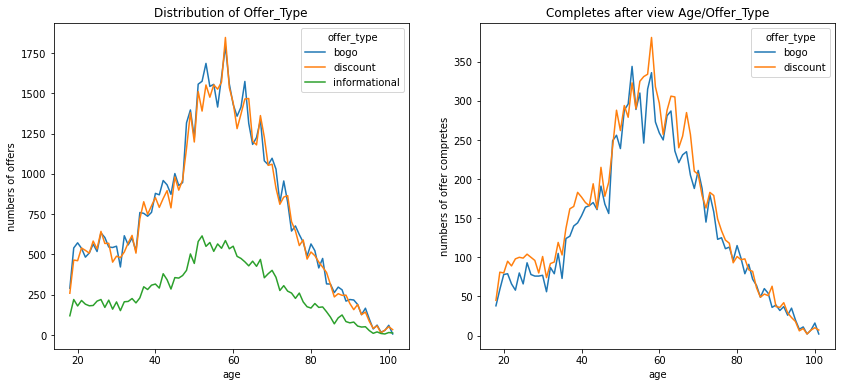

In [39]:
# plot the number of offers received by each offer type

fig, axes = plt.subplots(1,2, figsize=(14,6))

transcript.pivot_table('person', index='age', columns='offer_type', 
                    aggfunc='count').plot(title= 'Distribution of Offer_Type'
                                         , ylabel = 'numbers of offers'
                                          , ax = axes[0]);

# plot the numbers of offered completed after offer viewed
group_1.pivot_table('person', index='age', columns='offer_type', 
                    aggfunc='count').plot(title= 'Completes after view Age/Offer_Type'
                                         , ylabel = 'numbers of offer compretes'
                                          , ax = axes[1]);


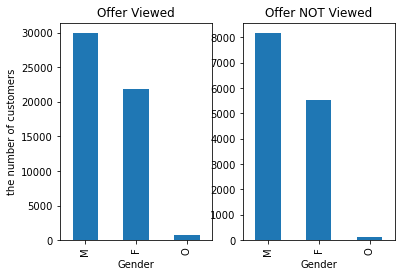

In [40]:
# plot the number of customers of 'offer viewed' and 'offer not viewed' with genders
fig, axes = plt.subplots(1,2)
group_3.gender.value_counts().plot(kind='bar', ax = axes[0], title = 'Offer Viewed', xlabel='Gender',ylabel='the number of customers');
group_4.gender.value_counts().plot(kind='bar', ax = axes[1], title = 'Offer NOT Viewed', xlabel='Gender');

In [41]:
def create_customers(df=transcript):
    
    '''
    create 'customers' df that is a customers who transacted at least once
    input: 'transaction' df
    output: 'customers' df
    '''
    
    # create customers df
    customers = df[['person', 'age','gender','loyalty','income']]
    # create 'amount' column of total amouts spent per each person
    amounts = df.groupby(['person']).sum()['amount']
    customers = customers.merge(amounts, on='person')
    customers.drop_duplicates(inplace=True)
    customers = customers.dropna()
    
    # create 'reward' column of total reward gained by each person
    reward =  df.groupby(['person']).sum()['reward_x']
    customers = customers.merge(reward, on='person')
    customers = customers.rename(columns ={'reward_x':'reward'})
    
    # create series of 'transaction' in the 'event' column
    transaction = df[['person','event']][df.event=='transaction']
    # total numbers of 'event'(all columns are 'transaction')
    transaction = transaction.groupby(['person']).count()['event']
    customers = customers.merge(transaction, on ='person')
    customers = customers.rename(columns={'event':'transaction'})
    
    # create 'completed' column of the number of offer completed by each person
    completion = df[['person','event']][df.event=='offer completed']
    # total numbers of 'event'(all columns are 'transaction')
    completion = completion.groupby(['person']).count()['event']       
    customers = customers.merge(completion, on ='person')
    customers = customers.rename(columns={'event': 'completed'})
    
    # create 'received' column of the number of offers received by each person
    received = df[['person','event']][df.event=='offer received']
    # total numbers of 'event'(all columns are 'transaction')
    received = received.groupby(['person']).count()['event']    
    customers = customers.merge(received, on ='person')
    customers = customers.rename(columns={'event': 'received'})
    
    # create 'rev_comp_ratio' column of the ration of offer completed per offer received by each person
    customers['rev_comp_ratio'] = customers.completed / customers.received
    
    return customers

customers = create_customers()
customers

,person,age,gender,loyalty,income,amount,reward,transaction,completed,received,rev_comp_ratio
0,0009655768c64bdeb2e877511632db8f,33.0,M,461.0,72000.0,127.60,9.0,8,3,5,0.60
1,0011e0d4e6b944f998e987f904e8c1e5,40.0,O,198.0,57000.0,79.46,13.0,5,3,5,0.60
2,0020c2b971eb4e9188eac86d93036a77,59.0,F,874.0,90000.0,196.86,14.0,8,3,5,0.60
3,0020ccbbb6d84e358d3414a3ff76cffd,24.0,F,622.0,60000.0,154.05,13.0,12,3,4,0.75
4,003d66b6608740288d6cc97a6903f4f0,26.0,F,400.0,73000.0,48.34,9.0,18,3,5,0.60
...,...,...,...,...,...,...,...,...,...,...,...
11981,fff29fb549084123bd046dbc5ceb4faa,59.0,F,329.0,93000.0,291.47,47.0,11,6,6,1.00
11982,fff3ba4757bd42088c044ca26d73817a,69.0,F,1040.0,83000.0,580.98,9.0,11,3,6,0.50
11983,fff7576017104bcc8677a8d63322b5e1,71.0,M,268.0,73000.0,29.94,9.0,6,3,5,0.60
11984,fffad4f4828548d1b5583907f2e9906b,34.0,M,549.0,34000.0,88.83,15.0,12,3,4,0.75


In [42]:
no_transaction_customers = personal_data[~personal_data.person.isin(customers.person)]
no_transaction_customers

,gender,age,person,became_member_on,income,loyalty
19,F,61,a448667f336b42c9a66fc5ffd5d73772,2018-05-01,40000.0,86
28,F,46,7429a044884842d6862f516c38b1156f,2017-09-11,59000.0,318
41,F,20,02c083884c7d45b39cc68e1314fec56c,2016-07-11,30000.0,745
59,M,45,186d6403f5824c739555b732f4af3f16,2017-10-06,48000.0,293
68,M,77,d8af520c4a8a4c77b921098d7d838c4d,2016-07-30,51000.0,726
...,...,...,...,...,...,...
16983,F,72,ff737c250d2343729ade04c4f6eb1001,2015-04-04,65000.0,1209
16985,M,26,97ee6e7a12fe4064b260fa48bdd0330f,2018-06-19,55000.0,37
16992,F,21,400d0536e8794cbb855b0d882d67cbda,2017-09-17,72000.0,312
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,52


In [43]:
# check the distribution of 'rev_comp_ratio' 
customers.rev_comp_ratio.describe()

count    11986.000000
mean         0.602817
std          0.256877
min          0.166667
25%          0.400000
50%          0.600000
75%          0.800000
max          1.000000
Name: rev_comp_ratio, dtype: float64

In [44]:
# create 'customers_no_interest' df that is a group of customers whose rev_comp_ratio is less 40%
# that is a indication of their interest in the offers
# those customers are lower 25% boundary of customers
customers_no_interest = customers[customers.rev_comp_ratio<=0.4]
customers_no_interest

,person,age,gender,loyalty,income,amount,reward,transaction,completed,received,rev_comp_ratio
5,00426fe3ffde4c6b9cb9ad6d077a13ea,19.0,F,716.0,65000.0,68.51,2.0,17,1,5,0.200000
8,005500a7188546ff8a767329a2f7c76a,56.0,M,229.0,47000.0,20.36,5.0,4,1,5,0.200000
11,0082fd87c18f45f2be70dbcbb0fb8aad,28.0,F,321.0,68000.0,121.85,10.0,7,2,5,0.400000
14,0099bf30e4cb4265875266eb3eb25eab,61.0,M,162.0,66000.0,105.83,7.0,9,2,5,0.400000
15,00a794f62b9a48beb58f8f6c02c2f1a6,88.0,F,1006.0,54000.0,166.40,5.0,11,1,5,0.200000
...,...,...,...,...,...,...,...,...,...,...,...
11952,ff464c1589c74bd7aa71ad8cf011bec5,66.0,F,276.0,50000.0,46.13,5.0,3,1,4,0.250000
11959,ff738e7080d742b9a6988cac1f59bda0,34.0,F,553.0,48000.0,38.12,3.0,11,1,3,0.333333
11967,ff95e0a9cdfd4030958762dadcb11e1a,79.0,M,432.0,93000.0,60.23,10.0,3,2,5,0.400000
11972,ffac285a64714aca8efd8d61a5606e84,28.0,M,277.0,36000.0,9.63,5.0,3,1,3,0.333333


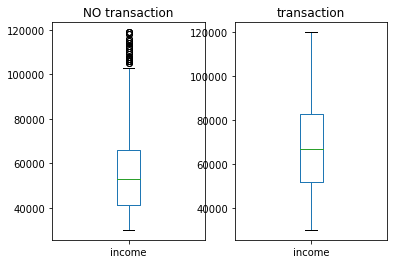

In [45]:
# plot 'income' per 'NO transaction' and 'transaction'
fig, axes = plt.subplots(1,2)
no_transaction_customers.income.plot(kind='box', ax = axes[0], title = 'NO transaction');
customers.income.plot(kind='box', ax=axes[1], title = 'transaction');

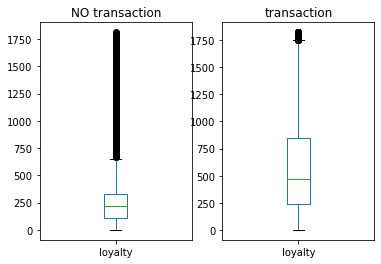

In [46]:
# plot 'loyalty' per 'NO transaction' and 'transaction'
fig, axes = plt.subplots(1,2)
no_transaction_customers.loyalty.plot(kind='box', ax = axes[0], title = 'NO transaction');
customers.loyalty.plot(kind='box', ax=axes[1], title = 'transaction');

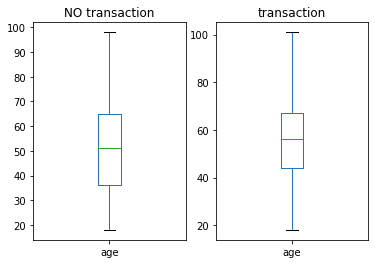

In [47]:
# plot 'age' of 'NO transaction' and 'transaction'
fig, axes = plt.subplots(1,2)
no_transaction_customers.age.plot(kind='box', ax = axes[0], title = 'NO transaction');
customers.age.plot(kind='box', ax=axes[1], title = 'transaction');

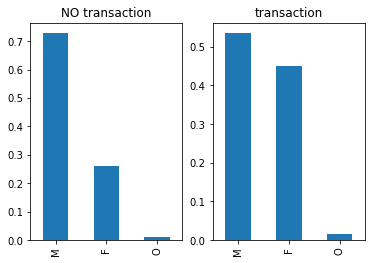

In [48]:
# plot 'gender' per 'NO transaction' and 'transaction'
fig, axes = plt.subplots(1,2)
no_transaction_customers.gender.value_counts(normalize=True).plot(kind='bar', ax = axes[0], title = 'NO transaction');
customers.gender.value_counts(normalize=True).plot(kind='bar', ax = axes[1], title = 'transaction');

In [49]:
customers.to_csv('customers.csv', index=False)

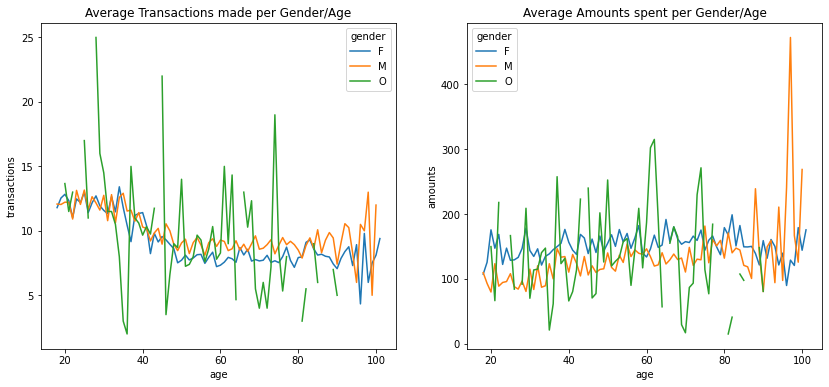

In [50]:
# plot the number of transaction age and genders
fig, axes = plt.subplots(1,2, figsize=(14,6))

customers.pivot_table('transaction', index='age', columns='gender', 
                      aggfunc='mean').plot(title = 'Average Transactions made per Gender/Age'
                                           , ylabel ='transactions'
                                           , ax=axes[0]);

# plot total amounts spent per age and genders
customers.pivot_table('amount', index='age', columns='gender', 
                      aggfunc='mean').plot(title='Average Amounts spent per Gender/Age'
                                           , ylabel='amounts'
                                           , ax=axes[1]);

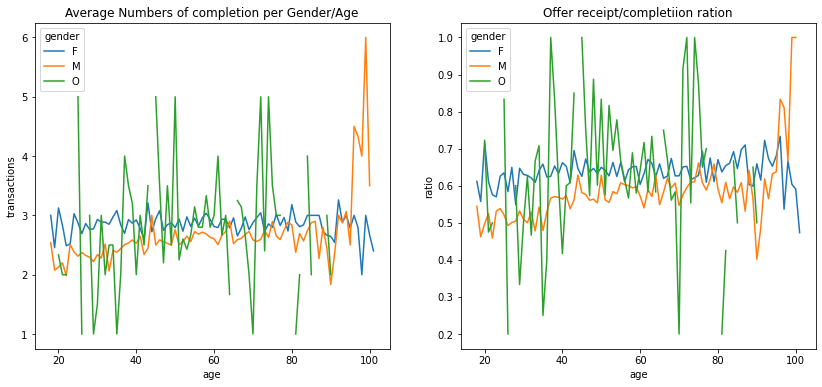

In [51]:
# plot the number of offer completed per age and genders
fig, axes = plt.subplots(1,2, figsize=(14,6))

customers.pivot_table('completed', index='age', columns='gender', 
                      aggfunc='mean').plot(title= 'Average Numbers of completion per Gender/Age'
                                           , ylabel = 'transactions'
                                           , ax =axes[0]);

# plot the ratio between offer received/completed per age and genders
customers.pivot_table('rev_comp_ratio', index='age', columns='gender', 
                      aggfunc='mean').plot(title= 'Offer receipt/completiion ration'
                                           , ylabel = 'ratio'
                                           , ax =axes[1]);

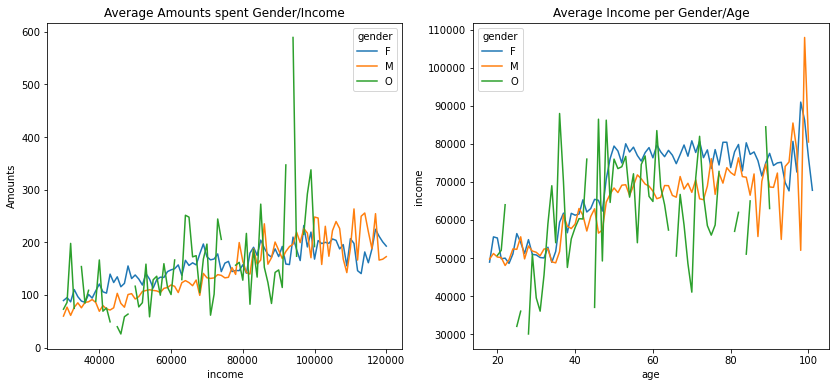

In [52]:
# plot average amounts spent per income and genders
fig, axes = plt.subplots(1,2, figsize=(14,6))

customers.pivot_table('amount', index='income', columns='gender', 
                      aggfunc='mean').plot(title = 'Average Amounts spent Gender/Income'
                                          , ylabel = 'Amounts'
                                          , ax =axes[0]);

# plot average income per age and genders
customers.pivot_table('income', index='age', columns='gender', 
                      aggfunc='mean').plot(title = 'Average Income per Gender/Age'
                                          , ylabel = 'income'
                                          , ax =axes[1]);

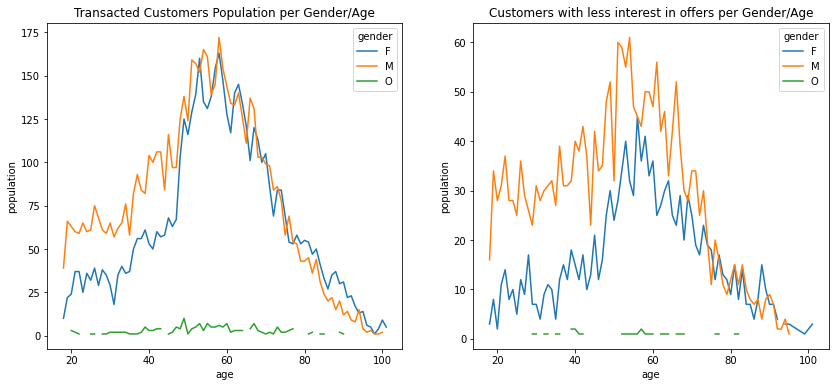

In [53]:
# plot the number of customers at least one transaction per age and genders
fig, axes = plt.subplots(1,2, figsize=(14,6))

customers.pivot_table('person', index='age', columns='gender', 
                      aggfunc='count').plot(title='Transacted Customers Population per Gender/Age'
                                           , ylabel = 'population'
                                           , ax = axes[0]);

# plot the number of customers with less attention to offers per age and genders
customers_no_interest.pivot_table('person', index='age', columns='gender', 
                                  aggfunc='count').plot(title = 'Customers with less interest in offers per Gender/Age'
                                                       , ylabel ='population'
                                                       , ax = axes[1]);

#### 1.5 Summary

- The customer population of male is larger than females throughout generation.
- Those series of figures show that the shape of customer population distribution looks like a normal distribution. More populated ages are 40-60 and younger people are less. Also, male are more populated than females. Very personal impression, It is a bit strange for me. In Japan, where I live, the situation is the opposite, Starbucks is popular for younger(students) and female people. It is not so popular for 50s man to have a cafe in Starbucks.
- The average income level for females is larger than male generally.
- The distribution trend of the customer population between female and male are close.
- The average amount spent for females is more than male in most ages, while the population of male is bigger than female. At the same time, numbers of offers  completed hence reward gained for females are larger than male.
- As a particular trend, a group of the older generation(90s) of male spend significantly larger amounts that is deviated from a general trend. They are maybe very loyal customers.
- Offers of any kind may not make a big impact on their action to buy although it is difficult to say about this from those data.
- The customers with less interest in offers(less than 40% of offers completed to the offer received((lower 25% boundary of total customers who made transaction))  has a particular feature that is the significant larger number of male compare to that of total customers. 
- In summary, it is fair to say that a more favorable target with higher possibility to respond to offers are females of 30s to 50s ages with higher incomes. 


## 2. Mechine Learning

### 2.1 Principal Component Analysis

In [54]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.cluster import KMeans

df_pca = pd.read_csv('group_1.csv')

In [55]:
df_pca.head(2)

,person,offer_id,time,event,reward_x,amount,offer_type,view,complete,gender,age,became_member_on,income,loyalty
0,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,252,offer completed,3.0,NaN,discount,1,1,O,40.0,2018-01-09,57000.0,198.0
1,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,576,offer completed,5.0,NaN,discount,1,1,O,40.0,2018-01-09,57000.0,198.0


In [56]:
def create_data_pca(df=df_pca):
    '''
    Create Dataframe for PCA
    - drop unnecessary columns
    - create dummy variables
    input: df(Dataframe)
    output: df(dataframe)
     '''
    df = df.drop(columns = ['reward_x','person','event','view','complete','became_member_on',
                            'amount','offer_type','time'])
    df.dropna(axis = 0, inplace=True)
    
    # dummy = pd.get_dummies(df[['gender','offer_type']])
    # df = df.join(dummy)
    df = pd.get_dummies(df)
    
    numerical = ['age','income','loyalty']
    scaler = StandardScaler()
    df[numerical] = scaler.fit_transform(df[numerical])
    
    return df        
                 
data_pca = create_data_pca(df_pca)
data_pca

,age,income,loyalty,offer_id_0b1e1539f2cc45b7b9fa7c272da2e1d7,offer_id_2298d6c36e964ae4a3e7e9706d1fb8c2,offer_id_2906b810c7d4411798c6938adc9daaa5,offer_id_4d5c57ea9a6940dd891ad53e9dbe8da0,offer_id_9b98b8c7a33c4b65b9aebfe6a799e6d9,offer_id_ae264e3637204a6fb9bb56bc8210ddfd,offer_id_f19421c1d4aa40978ebb69ca19b0e20d,offer_id_fafdcd668e3743c1bb461111dcafc2a4,gender_F,gender_M,gender_O
0,-0.945407,-0.563564,-0.996200,0,1,0,0,0,0,0,0,0,0,1
1,-0.945407,-0.563564,-0.996200,1,0,0,0,0,0,0,0,0,0,1
2,-0.945407,-0.563564,-0.996200,0,0,0,0,1,0,0,0,0,0,1
3,0.193975,0.994170,0.687741,0,0,0,0,0,0,0,1,1,0,0
4,0.193975,0.994170,0.687741,0,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25010,-0.645569,-0.327544,0.025126,0,0,0,0,0,0,0,1,1,0,0
25011,-0.645569,-0.327544,0.025126,1,0,0,0,0,0,0,0,1,0,0
25012,-0.645569,-0.327544,0.025126,0,0,1,0,0,0,0,0,1,0,0
25013,-0.645569,-0.327544,0.025126,0,0,1,0,0,0,0,0,1,0,0


In [57]:
def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    X = data_pca
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    
    return pca, X_pca

pca, X_pca = do_pca(5, data_pca)


In [58]:
def pca_results(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n%.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

,Explained Variance,age,income,loyalty,offer_id_0b1e1539f2cc45b7b9fa7c272da2e1d7,offer_id_2298d6c36e964ae4a3e7e9706d1fb8c2,offer_id_2906b810c7d4411798c6938adc9daaa5,offer_id_4d5c57ea9a6940dd891ad53e9dbe8da0,offer_id_9b98b8c7a33c4b65b9aebfe6a799e6d9,offer_id_ae264e3637204a6fb9bb56bc8210ddfd,offer_id_f19421c1d4aa40978ebb69ca19b0e20d,offer_id_fafdcd668e3743c1bb461111dcafc2a4,gender_F,gender_M,gender_O
Dimension 1,0.3041,0.6912,0.7002,-0.0364,0.0053,-0.0170,0.0010,0.0182,0.0010,0.0054,-0.0002,-0.0136,0.1225,-0.1215,-0.0011
Dimension 2,0.2292,0.0308,0.0410,0.9955,-0.0014,-0.0003,0.0036,-0.0046,0.0022,-0.0089,-0.0012,0.0105,-0.0543,0.0565,-0.0022
Dimension 3,0.1592,0.7202,-0.6872,-0.0016,-0.0025,0.0116,0.0019,-0.0154,0.0006,-0.0097,0.0025,0.0109,-0.0663,0.0645,0.0018
Dimension 4,0.1049,-0.0514,-0.1865,0.0865,0.0005,-0.0103,-0.0037,0.0171,0.0003,0.0098,-0.0020,-0.0116,0.6900,-0.6917,0.0017
Dimension 5,0.0415,-0.0012,0.0010,-0.0084,-0.0092,-0.6166,-0.0186,-0.0287,-0.0195,-0.0263,-0.0642,0.7831,0.0036,-0.0024,-0.0013


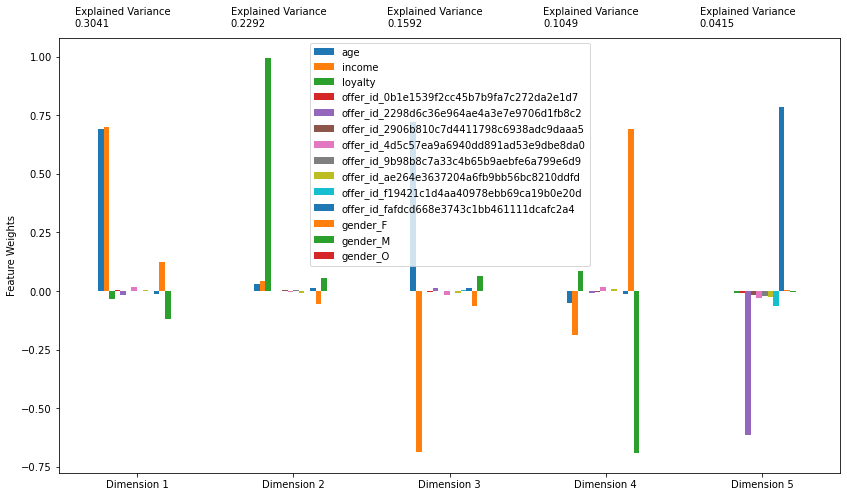

In [59]:
pca_results(data_pca,pca)

### 2.2 Supervised Learning 
To build a model that predicts whether or not someone will view or not.

In [68]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, accuracy_score
import time
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import visuals as vs

In [69]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
   
    sample_size= int(sample_size)  
    start = time.time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size]) # None
    end = time.time()  # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start 
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time.time() # Get start time
    predictions_test = learner.predict(X_test) 
    predictions_train = learner.predict(X_train[:300]) 
    end = time.time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = np.sum((predictions_train[:300] == y_train[:300]) / 300 ) 
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test) 
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train[:300], beta = 0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta = 0.5) 
       
    
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    return results

In [70]:
def create_data_notview(df):
    
    '''
    create data for supervised lerning whether or not someone will complete after view offer
    input: pd Dataframe 'Group'
    output: data for supervised lerning
    '''
    # drop unnecessary columns        
    df = df.drop(columns = ['person','offer_id','offer_type','became_member_on'])
    
    # standarize
    scaler = StandardScaler()
    numerical = ['age','income','loyalty']
    df[numerical] = scaler.fit_transform(df[numerical]) 
    # drop nan
    df.dropna(axis = 0, inplace=True)
    # convert categorical variable into dummy variable
    df = pd.get_dummies(df)    
          
    return df

data_notview = create_data_notview(group_notview)
data_notview.head()

,viewed,mail_mb_sns,wb_mail_mb_sns,wb_mail_mb,wb_mail,age,income,loyalty,gender_F,gender_M,gender_O
0,1,1,0,0,0,-1.22845,0.306541,-0.145275,0,1,0
1,1,0,0,1,0,-1.22845,0.306541,-0.145275,0,1,0
2,1,0,1,0,0,-1.22845,0.306541,-0.145275,0,1,0
3,1,0,1,0,0,-1.22845,0.306541,-0.145275,0,1,0
4,0,0,0,1,0,-1.22845,0.306541,-0.145275,0,1,0


In [74]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X, y = data_notview.iloc[:,1:], data_notview.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 53200 samples.
Testing set has 13301 samples.


In [75]:
# define True Positive, False Positive, True Negative and False Negative
TP = np.sum(data_notview['viewed'])
FP = data_notview['viewed'].value_counts()[0]
TN = 0
FN = 0

# define accuracy, recall and precision
accuracy = TP / (TP + TN + FP + FN)
recall = TP / (TP + FN)
precision = TP / (TP + FP)

# define F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1 + 0.5 * 0.5) * ( precision * recall) / ((0.5 * 0.5 * precision) + recall)


LogisticRegression trained on 532 samples.
LogisticRegression trained on 5320 samples.
LogisticRegression trained on 53200 samples.
SVC trained on 532 samples.
SVC trained on 5320 samples.
SVC trained on 53200 samples.
AdaBoostClassifier trained on 532 samples.
AdaBoostClassifier trained on 5320 samples.
AdaBoostClassifier trained on 53200 samples.


C:\Users\wythe\Starbucks\visuals.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  pl.tight_layout()


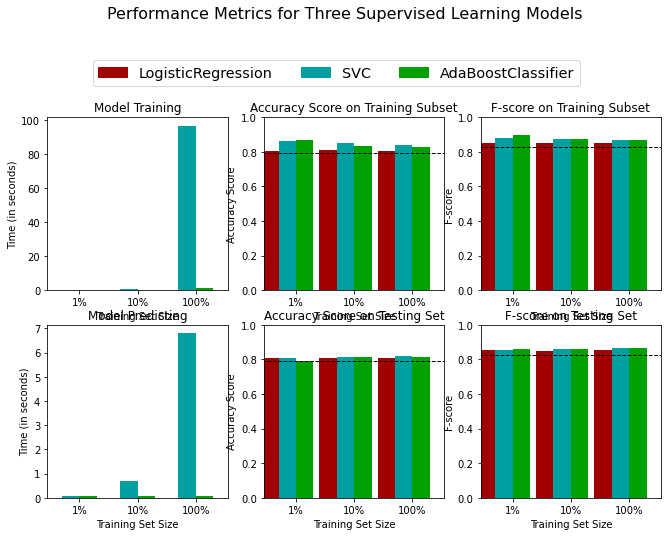

In [76]:
# Initialize the three models
clf_A = LogisticRegression(random_state=42)
clf_B = SVC(random_state=42)
clf_C = AdaBoostClassifier(random_state=42)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int(samples_100 * 0.1)
samples_1 = int(samples_100 * 0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [77]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV

# Initialize the classifier
clf =  AdaBoostClassifier(random_state=42)# None

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters =  {"base_estimator" : [DecisionTreeClassifier(max_depth=x) 
                                  for x in range(5, 10)],
              "learning_rate" : [0.5, 1.0, 1.5]}
    

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5) #None

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer) # None

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train) # None

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8166
F-score on testing data: 0.8633

Optimized Model
------
Final accuracy score on the testing data: 0.8157
Final F-score on the testing data: 0.8716


In [78]:
# print best classifier
best_clf

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=6),
                   learning_rate=0.5, random_state=42)

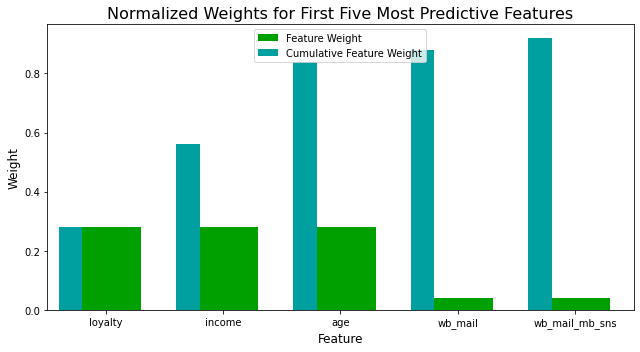

In [79]:
# Import a supervised learning model that has 'feature_importances_'
from sklearn.datasets import make_classification


#Train the supervised model on the training set using .fit(X_train, y_train)
model = clf.fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = clf.feature_importances_ 

# Plot
vs.feature_plot(importances, X_train, y_train)

In [80]:
# print indicies 
indices = np.argsort(importances)[::-1]
X_train.columns.values[indices[:8]]

array(['loyalty', 'income', 'age', 'wb_mail', 'wb_mail_mb_sns',
       'mail_mb_sns', 'gender_O', 'gender_F'], dtype=object)

### 2.3 Random Forest Classifier

In [81]:
customers.amount.describe()

count    11986.000000
mean       139.656339
std        133.464066
min          5.280000
25%         57.352500
50%        112.255000
75%        179.690000
max       1608.690000
Name: amount, dtype: float64

In [82]:
customers.transaction.describe()

count    11986.000000
mean         9.218588
std          5.119916
min          1.000000
25%          5.000000
50%          8.000000
75%         12.000000
max         36.000000
Name: transaction, dtype: float64

In [83]:
def create_data_lreg(df):
    '''
    '''
    
    df['amount_spent'] = np.where((df['amount'] >= 112),1,0)
    df['transaction_made'] = np.where((df['transaction'] >= 8),1,0)
    df[['M','F','O']] = pd.get_dummies(df['gender'])
   
    
    return df

customers_lreg = create_data_lreg(customers)
customers_lreg

,person,age,gender,loyalty,income,amount,reward,transaction,completed,received,rev_comp_ratio,amount_spent,transaction_made,M,F,O
0,0009655768c64bdeb2e877511632db8f,33.0,M,461.0,72000.0,127.60,9.0,8,3,5,0.60,1,1,0,1,0
1,0011e0d4e6b944f998e987f904e8c1e5,40.0,O,198.0,57000.0,79.46,13.0,5,3,5,0.60,0,0,0,0,1
2,0020c2b971eb4e9188eac86d93036a77,59.0,F,874.0,90000.0,196.86,14.0,8,3,5,0.60,1,1,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,24.0,F,622.0,60000.0,154.05,13.0,12,3,4,0.75,1,1,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,26.0,F,400.0,73000.0,48.34,9.0,18,3,5,0.60,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11981,fff29fb549084123bd046dbc5ceb4faa,59.0,F,329.0,93000.0,291.47,47.0,11,6,6,1.00,1,1,1,0,0
11982,fff3ba4757bd42088c044ca26d73817a,69.0,F,1040.0,83000.0,580.98,9.0,11,3,6,0.50,1,1,1,0,0
11983,fff7576017104bcc8677a8d63322b5e1,71.0,M,268.0,73000.0,29.94,9.0,6,3,5,0.60,0,0,0,1,0
11984,fffad4f4828548d1b5583907f2e9906b,34.0,M,549.0,34000.0,88.83,15.0,12,3,4,0.75,0,1,0,1,0


In [84]:
def create_rmf(df):
    '''
    '''
    df =df[['transaction_made','age','loyalty','income','M','F','O']]
    
    return df

data_rmf = create_rmf(customers_lreg)
data_rmf.head()

,transaction_made,age,loyalty,income,M,F,O
0,1,33.0,461.0,72000.0,0,1,0
1,0,40.0,198.0,57000.0,0,0,1
2,1,59.0,874.0,90000.0,1,0,0
3,1,24.0,622.0,60000.0,1,0,0
4,1,26.0,400.0,73000.0,1,0,0


 1) loyalty                        0.449290
 2) income                         0.291954
 3) age                            0.248266
 4) M                              0.004471
 5) F                              0.004266
 6) O                              0.001752


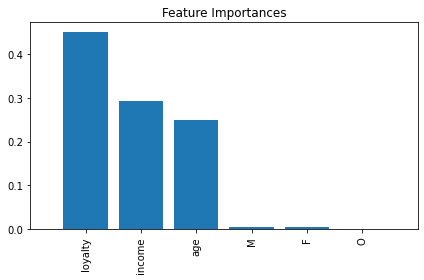

In [85]:
def randomforest(df):
    '''
    '''
    X, y = df.iloc[:,1:], df.iloc[:, 0].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,  
                                                    test_size = 0.2, 
                                                    random_state = 0, stratify=y)
    
    feat_labels = df.columns[1:]
    
    forest = RandomForestClassifier(n_estimators =500, random_state =1)
    
    forest.fit(X_train, y_train)
    
    importances = forest.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    for f in range(X_train.shape[1]):
        print("%2d) %-*s %f" %
          (f+1, 30, feat_labels[indices[f]], importances[indices[f]]))

    plt.title('Feature Importances')
    plt.bar(range(X_train.shape[1]), importances[indices], align='center')
    plt.xticks(range(X_train.shape[1]),feat_labels[indices], rotation=90)
    plt.xlim([-1, X_train.shape[1]])
    plt.tight_layout()
    plt.show()

randomforest(data_rmf)

 1) loyalty                        0.459239
 2) income                         0.276984
 3) age                            0.241384
 4) F                              0.010679
 5) M                              0.010428
 6) O                              0.001287


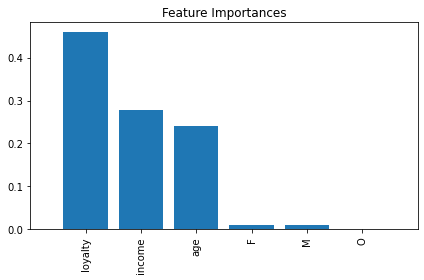

In [86]:
def create_rmf(df):
    '''
    '''
    df =df[['amount_spent','age','loyalty','income','M','F','O']]
    
    return df

data_rmf_amount = create_rmf(customers_lreg)

randomforest(data_rmf_amount)

In [87]:
data_svl

NameError: name 'data_svl' is not defined

In [ ]:
randomforest(data_svl)